#### 예측값 생성 예제 lstm기반 전력량 예측

In [ ]:
#데이터를 분리 - 훈련데이터와 테스트 데이터 배열 생성 -> 해당 데이터 표준화 -> X,y 변수에 초기화 ->모델정의(레이어들 add)->모델 컴파일 -> 모델 학습 -> 그 학습 모델 save

In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np
import os
from sqlalchemy import create_engine, text
import pymysql
import sqlalchemy

In [28]:
# 데이터 로드
df_concat = pd.read_csv('../dataSet/watertot.csv', encoding="CP949")
df_concat.head()

,일자,총유입수량,전력량
0,2021-01-01,6134,15335.0
1,2021-01-02,6155,15387.5
2,2021-01-03,6024,15060.0
3,2021-01-04,6011,15027.5
4,2021-01-05,6025,15062.5


In [29]:
# 폰트지정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 부호 깨짐 지정
plt.rcParams['axes.unicode_minus'] = False

# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = '{:.2f}'.format

In [64]:
df_concat['일자'] =pd.to_datetime(df_concat['일자'])
df_concat

,일자,총유입수량,전력량
0,2021-01-01,6134,15335.00
1,2021-01-02,6155,15387.50
2,2021-01-03,6024,15060.00
3,2021-01-04,6011,15027.50
4,2021-01-05,6025,15062.50
...,...,...,...
1091,2024-12-27,6528,16320.00
1092,2024-12-28,6650,16625.00
1093,2024-12-29,6998,17495.00
1094,2024-12-30,7753,19382.50


In [33]:
# 이상값 제거
df_concat = df_concat[(df_concat['총유입수량']-df_concat['총유입수량'].mean()).abs() < 3 * df_concat['총유입수량'].std()]
df_concat = df_concat[(df_concat['전력량']-df_concat['전력량'].mean()).abs()< 3* df_concat['전력량'].std()]

In [34]:
# 훈련데이터와 테스트 데이터 나누기
df_concat = df_concat.sort_values(by='일자')
train_size = 0.8
split_index = int(len(df_concat) * train_size)
train,test = df_concat[:split_index],df_concat[split_index:]

In [66]:
# 표준화
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['총유입수량','전력량']])
test_scaled = scaler.transform(test[['총유입수량','전력량']])

train_scaled.shape

(852, 2)

In [35]:
# 쪼갤단위
s_len = 7

In [38]:
# X -> [샘플 수, 시퀀스 길이,feature 수]
def create_data(data,s_len):
    X,y =[],[]
    for i in range(len(data)-s_len):
        X.append(data[i:i +s_len,:-1])
        y.append(data[i +s_len,-1])
    return np.array(X), np.array(y).reshape(-1,1)

In [43]:

X_train, y_train = create_data(train_scaled,s_len)
X_test,y_test = create_data(test_scaled,s_len)
X_train.shape


(845, 7, 1)

In [44]:
# input_shape(시퀀스 길이, feature 수)
model = Sequential()
model.add(LSTM(64,activation='tanh',return_sequences='True',input_shape=(s_len,X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))

c:\study_python_3106\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [46]:
h = model.fit(X_train,y_train,epochs=10,batch_size=16,validation_data=(X_test,y_test),verbose=2,shuffle=False)

Epoch 1/10
53/53 - 3s - 62ms/step - loss: 0.5772 - val_loss: 0.5078
Epoch 2/10
53/53 - 0s - 7ms/step - loss: 0.4691 - val_loss: 0.4436
Epoch 3/10
53/53 - 0s - 7ms/step - loss: 0.4379 - val_loss: 0.4324
Epoch 4/10
53/53 - 0s - 6ms/step - loss: 0.4262 - val_loss: 0.4407
Epoch 5/10
53/53 - 0s - 6ms/step - loss: 0.4167 - val_loss: 0.4198
Epoch 6/10
53/53 - 0s - 6ms/step - loss: 0.3978 - val_loss: 0.3925
Epoch 7/10
53/53 - 0s - 7ms/step - loss: 0.3785 - val_loss: 0.3868
Epoch 8/10
53/53 - 0s - 7ms/step - loss: 0.3799 - val_loss: 0.3816
Epoch 9/10
53/53 - 0s - 7ms/step - loss: 0.3699 - val_loss: 0.3827
Epoch 10/10
53/53 - 0s - 7ms/step - loss: 0.3761 - val_loss: 0.3800


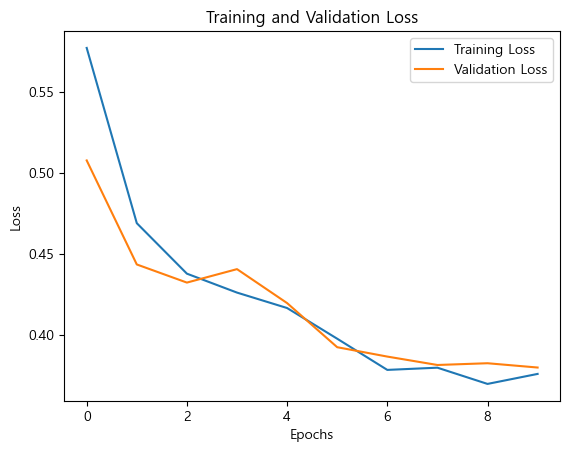

In [47]:
plt.plot(h.history['loss'],label='Training Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [48]:
model.save('../save_model/lstm_model.keras')

In [52]:
y_predict = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


In [87]:
# 데이터 다시 역변환, 예측값은 s_len 입력값 이후에 나옴(시퀀스 길이가 7이라면 8번째에서 예측값)
y_pred_inverse = scaler.inverse_transform(np.concatenate( (test_scaled[s_len:,:-1],y_predict) , axis=1 ) )[:,-1]
y_test_inverse = scaler.inverse_transform(np.concatenate((test_scaled[s_len:,:-1],y_test),axis=1))[:,-1]

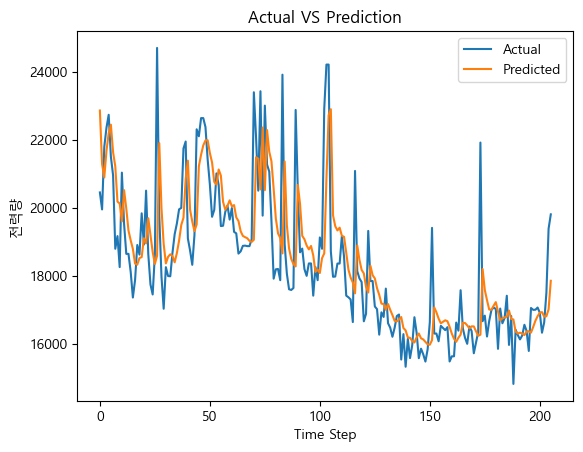

In [63]:
plt.plot(y_test_inverse, label='Actual')
plt.plot(y_pred_inverse,label='Predicted')
plt.title('Actual VS Prediction')
plt.xlabel('Time Step')
plt.ylabel('전력량')
plt.legend()
plt.show()

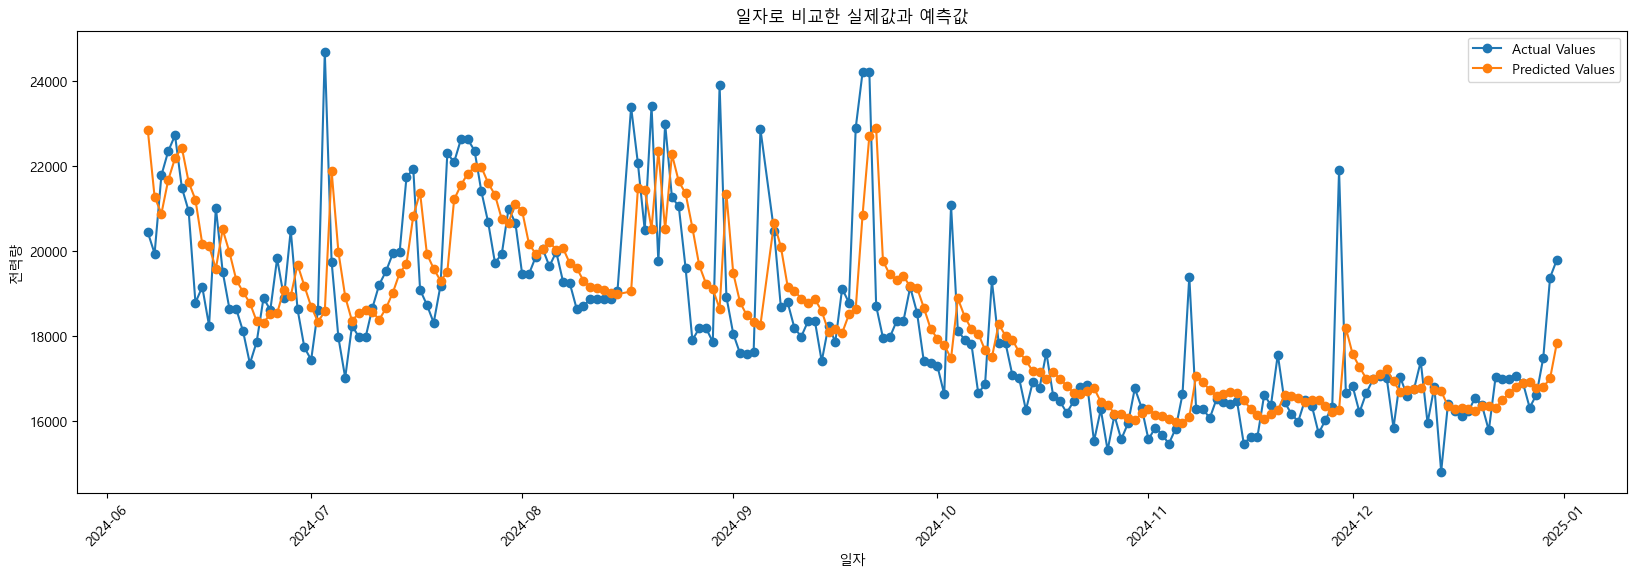

In [68]:
plt.figure(figsize=(20,6))
plt.plot(df_concat['일자'][split_index+s_len:],y_test_inverse,label='Actual Values',marker='o')
plt.plot(df_concat['일자'][split_index+s_len:],y_pred_inverse,label='Predicted Values',marker='o')
plt.title('일자로 비교한 실제값과 예측값')
plt.xlabel('일자')
plt.ylabel('전력량')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [71]:
compare_df = pd.DataFrame({
    'Date': df_concat['일자'][split_index+s_len:],
    'Predicted_Values': y_pred_inverse,
    'Actual_Values': y_test_inverse
})
compare_df

,Date,Predicted_Values,Actual_Values
888,2024-06-07,22857.90,20447.50
889,2024-06-08,21279.92,19947.50
890,2024-06-09,20887.74,21790.00
891,2024-06-10,21676.59,22355.00
892,2024-06-11,22190.31,22732.50
...,...,...,...
1091,2024-12-27,16925.54,16320.00
1092,2024-12-28,16793.05,16625.00
1093,2024-12-29,16803.42,17495.00
1094,2024-12-30,17006.93,19382.50


In [77]:
# 최종일자 다음날 예측할 데이터준비
last_s = train_scaled[-s_len:,:-1]
last_s = np.expand_dims(last_s,axis=0)
last_s


array([[[1.0591754 ],
        [0.95246728],
        [1.3226791 ],
        [0.68678586],
        [2.8993459 ],
        [1.71357923],
        [2.63148676]]])

In [80]:
# 예측
pred_nextday_scaled = model.predict(last_s)
pred_nextday = scaler.inverse_transform(np.concatenate((train_scaled[-1:,:-1], pred_nextday_scaled), axis=1))[:,-1]
print('최종일자 다음날 전력량 예측값',pred_nextday[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
최종일자 다음날 전력량 예측값 23109.770948193098


In [ ]:
# 최종일자 다음 1주일 예측을 위한 데이터 준비
last_s = train_scaled[-s_len:,:-1]
last_s = np.expand_dims(last_s,axis=0)

In [84]:
# 일주일 예측
future_predictions=[]
for _ in range(7):
    pred_scaled = model.predict(last_s)
    print('반복',pred_scaled)
    future_predictions.append(pred_scaled[0][0])
    new_sq = np.append(last_s[:,1:,:],pred_scaled.reshape(1,1,-1),axis=1)
    last_s = new_sq

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
반복 [[1.9125851]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
반복 [[1.9076254]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
반복 [[1.9032161]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
반복 [[1.8998643]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
반복 [[1.8973774]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
반복 [[1.8952985]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
반복 [[1.8933232]]


In [85]:
# 예측값 역변환
fu_pred_scaled =[]
for i in future_predictions:
    value = scaler.inverse_transform(np.concatenate(
        (train_scaled[-1:,:-1],np.array([[i]])),axis=1
    ))[:,:-1][0]
    fu_pred_scaled.append(value)